In [1]:
import torch
from torch import nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1 生成数据并显示

In [3]:
path_youwu = "F:\OneDrive\AI资料\机器学习\浩杰给的课件\pytorch\实验数据\去雾数据集\有雾图片"
path_quwu = "F:\OneDrive\AI资料\机器学习\浩杰给的课件\pytorch\实验数据\去雾数据集\去雾图片"

def readImagesToNumpy(path):
    x = []
    for filename in os.listdir(path, ):
        #print(filename)
        file = path + '\\' + filename
        img = Image.open(file)
        img = img.resize((200, 100), Image.ANTIALIAS) #read the image
        img = np.transpose(img, (2, 0, 1))
        img = np.array(img) # transform to numpy
        img = img / 255 # normalize
        #plt.imshow(img)
        #plt.show()
        #print(img.shape)
        x.append(img)
        #break
    return x

X = readImagesToNumpy(path_youwu)
y = readImagesToNumpy(path_quwu)
X = torch.tensor(X)
y = torch.tensor(y)

train_num = len(X)*4//5
X_train = X[:train_num, :]
y_train = y[:train_num, :]
X_test = X[train_num:, :]
y_test = y[train_num:, :]

print(X.shape, X.device, y.shape, y.device)

torch.Size([520, 3, 100, 200]) cpu torch.Size([520, 3, 100, 200]) cpu


## 2 读取数据

torch.Size([64, 3, 100, 200]) torch.Size([64, 3, 100, 200])


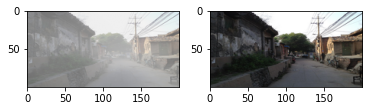

torch.Size([64, 3, 100, 200]) torch.Size([64, 3, 100, 200])


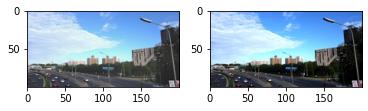

torch.Size([64, 3, 100, 200]) torch.Size([64, 3, 100, 200])


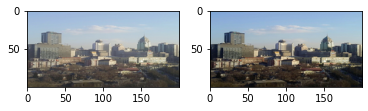

torch.Size([64, 3, 100, 200]) torch.Size([64, 3, 100, 200])


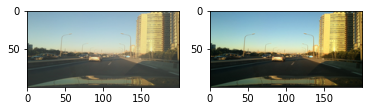

torch.Size([64, 3, 100, 200]) torch.Size([64, 3, 100, 200])


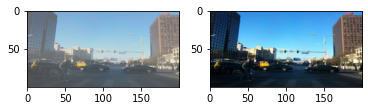

torch.Size([64, 3, 100, 200]) torch.Size([64, 3, 100, 200])


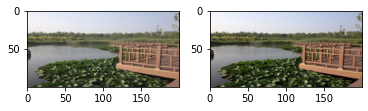

torch.Size([32, 3, 100, 200]) torch.Size([32, 3, 100, 200])


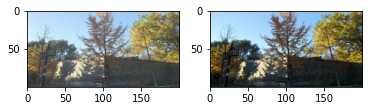

In [4]:
batch_size = 64
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
#)
#transform(X_train[0, :])
#print(X_train[0,:])
#transform(y_train)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X, y in train_loader:
    print(X.shape, y.shape)
    plt.subplot(121)
    img = X[0, :]
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    plt.subplot(122)
    img = y[0, :]
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    plt.show()

## 3 定义卷积层和模型

In [5]:
def corr2d(X, K):
    X = torch.constant_pad_nd(X, (1, 1, 1, 1)) #加了一层padding
    batch_size, H, W = X.shape
    h_k, w_k = K.shape
    Y = torch.zeros((batch_size, H - h_k + 1, W - w_k + 1)).to(device)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[2]):
            Y[:, i, j] = (X[:, i : i + h_k, j : j + w_k] * K).sum()
    return Y

def corr2d_multi_in(X, K):
    res = corr2d(X[:, 0, :, :], K[0, :, :])
    for i in range(1, X.shape[1]):
        res += corr2d(X[:, i, :, :], K[i, :, :])
    return res

def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=1)

class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConv2D, self).__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels, 1, 1))

    def forward(self, x):
        return corr2d_multi_in_out(x, self.weight) + self.bias

In [6]:
class MyConvModule(nn.Module):
    def __init__(self):
        super(MyConvModule, self).__init__()
        self.conv = nn.Sequential(
            MyConv2D(in_channels=3, out_channels=3, kernel_size=3), #改变了H和W，应该out-1或者padding=1
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
    def forward(self, X):
        out = self.conv(X)
        return out


## 4 定义模型参数

In [7]:
epochs = 10
lr = 0.003

net = MyConvModule().to(device)

criterion = nn.MSELoss(size_average=True).to(device)

optimizer = optim.Adam(net.parameters(), lr=lr)

## 5 训练模型

In [8]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')

In [15]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X = X.to(device).float()
            y = y.to(device).float()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 反向传播 + 更新优化参数
            l = loss(net(X), y).sum()
            l.backward()
            if optimizer == None:
                SGD(params, lr)
            else:
                optimizer.step()
            
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
        print('epoch %d, train_loss %.4f, test_loss %.4f' % (epoch + 1, train_ls[-1], train_ls[-1]))
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])

In [16]:
train_loss, test_loss = train(net, train_loader, test_loader, criterion, epochs, batch_size, None, None, optimizer)